# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_Barlow_Twins_mixup_0.4_batchnorm/dcase2021_task2/ano_VAE+Centerloss/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [15]:
#path='/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/test_ex22/models/ToyCar_model.pth'
#pretrained_dict = torch.load(path)

In [16]:
#pretrained_dict['center_loss.centers'].shape

In [17]:
#pretrained_dict['center_loss.centers']

2021-08-13 12:30:25,217 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-08-13 12:30:25,218 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:30:26,102 - 00_train.py - INFO - TRAINING
2021-08-13 12:30:29,275 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 14.64it/s]
2021-08-13 12:30:30,097 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.89it/s]
2021-08-13 12:30:30,144 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.50it/s]


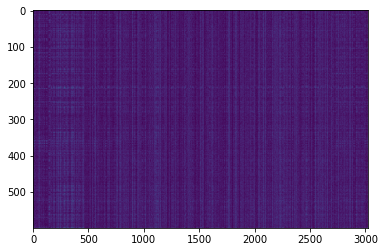

AUC      pAUC
Source_0  0.454100  0.487895
Source_1  0.492200  0.483684
Source_2  0.347600  0.492632
Target_0  0.537400  0.515263
Target_1  0.567900  0.503684
Target_2  0.457300  0.502632
mean      0.476083  0.497632
h_mean    0.464427  0.497403

2021-08-13 12:30:31,426 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:41092.155599, val_AUC_hmean:0.464427, val_pAUC_hmean:0.497403, best_flag:True
2021-08-13 12:30:31,427 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.22it/s]
2021-08-13 12:30:31,904 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.12it/s]
2021-08-13 12:30:31,947 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.44it/s]


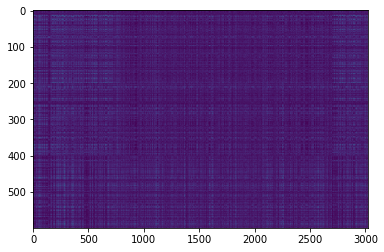

AUC      pAUC
Source_0  0.452800  0.490526
Source_1  0.485400  0.483684
Source_2  0.337000  0.491579
Target_0  0.542600  0.520526
Target_1  0.605300  0.506842
Target_2  0.450500  0.499474
mean      0.478933  0.498772
h_mean    0.463292  0.498480

2021-08-13 12:30:33,139 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:34780.540365, val_AUC_hmean:0.463292, val_pAUC_hmean:0.498480, best_flag:True
2021-08-13 12:30:33,140 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.54it/s]
2021-08-13 12:30:33,611 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.67it/s]
2021-08-13 12:30:33,656 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.58it/s]


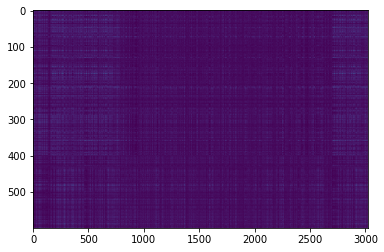

AUC      pAUC
Source_0  0.458600  0.495263
Source_1  0.503600  0.486316
Source_2  0.354600  0.499474
Target_0  0.544700  0.528947
Target_1  0.633200  0.513684
Target_2  0.447200  0.495263
mean      0.490317  0.503158
h_mean    0.474773  0.502769

2021-08-13 12:30:34,814 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:31940.064616, val_AUC_hmean:0.474773, val_pAUC_hmean:0.502769, best_flag:True
2021-08-13 12:30:34,815 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.21it/s]
2021-08-13 12:30:35,420 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.35it/s]
2021-08-13 12:30:35,467 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.06it/s]


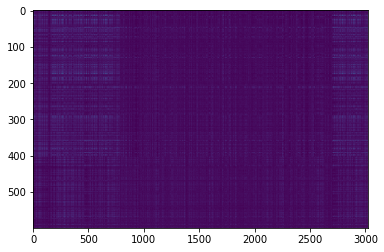

AUC      pAUC
Source_0  0.472900  0.498947
Source_1  0.514400  0.491053
Source_2  0.360600  0.495263
Target_0  0.553400  0.528947
Target_1  0.652900  0.516316
Target_2  0.450300  0.498421
mean      0.500750  0.504825
h_mean    0.484216  0.504478

2021-08-13 12:30:36,593 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:30068.668457, val_AUC_hmean:0.484216, val_pAUC_hmean:0.504478, best_flag:True
2021-08-13 12:30:36,594 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.88it/s]
2021-08-13 12:30:37,026 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 68.76it/s]
2021-08-13 12:30:37,084 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 72.65it/s]


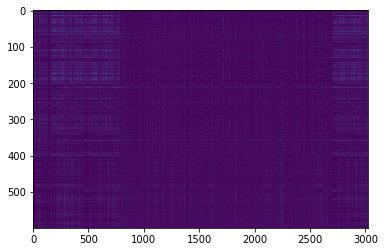

AUC      pAUC
Source_0  0.483900  0.503684
Source_1  0.535000  0.498421
Source_2  0.358200  0.494737
Target_0  0.556700  0.527368
Target_1  0.666400  0.535263
Target_2  0.437900  0.501053
mean      0.506350  0.510088
h_mean    0.487489  0.509631

2021-08-13 12:30:38,248 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:28716.943522, val_AUC_hmean:0.487489, val_pAUC_hmean:0.509631, best_flag:True
2021-08-13 12:30:38,249 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.38it/s]
2021-08-13 12:30:38,724 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.44it/s]
2021-08-13 12:30:38,766 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.38it/s]
2021-08-13 12:30:38,810 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:27717.042643, val_AUC_hmean:0.488161, val_pAUC_hmean:0.506664, best_flag:False
2021-08-13 12:30:38,811 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.04it/s]
2021-08-13 12:30:39,240 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.95it/s]
2021-08-13 12:30:39,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.13it/s]


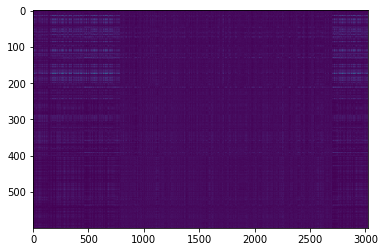

AUC      pAUC
Source_0  0.517600  0.516316
Source_1  0.549300  0.501579
Source_2  0.348800  0.495263
Target_0  0.559400  0.534737
Target_1  0.677900  0.542105
Target_2  0.431500  0.506842
mean      0.514083  0.516140
h_mean    0.491814  0.515580

2021-08-13 12:30:40,361 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:26929.130046, val_AUC_hmean:0.491814, val_pAUC_hmean:0.515580, best_flag:True
2021-08-13 12:30:40,362 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.81it/s]
2021-08-13 12:30:40,848 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.19it/s]
2021-08-13 12:30:40,891 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.18it/s]
2021-08-13 12:30:40,937 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:26466.366374, val_AUC_hmean:0.482495, val_pAUC_hmean:0.511603, best_flag:False
2021-08-13 12:30:40,938 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.49it/s]
2021-08-13 12:30:41,411 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.67it/s]
2021-08-13 12:30:41,449 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.65it/s]


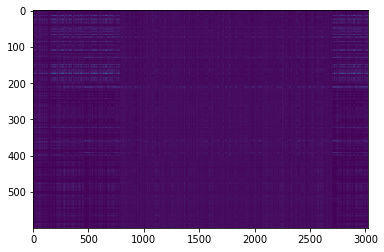

AUC      pAUC
Source_0  0.542500  0.518947
Source_1  0.586600  0.531579
Source_2  0.349500  0.491053
Target_0  0.561200  0.527895
Target_1  0.684500  0.556842
Target_2  0.430400  0.503158
mean      0.525783  0.521579
h_mean    0.501022  0.520733

2021-08-13 12:30:42,673 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:25930.512858, val_AUC_hmean:0.501022, val_pAUC_hmean:0.520733, best_flag:True
2021-08-13 12:30:42,674 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.87it/s]
2021-08-13 12:30:43,160 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.09it/s]
2021-08-13 12:30:43,212 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 87.69it/s]


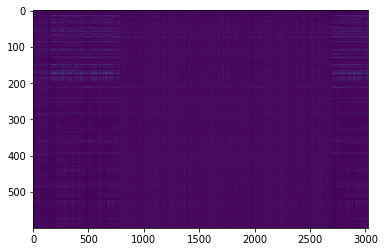

AUC      pAUC
Source_0  0.542200  0.520526
Source_1  0.568300  0.524737
Source_2  0.328500  0.487895
Target_0  0.551300  0.525263
Target_1  0.688400  0.562105
Target_2  0.433100  0.510526
mean      0.518633  0.521842
h_mean    0.490854  0.520921

2021-08-13 12:30:44,387 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:25447.938151, val_AUC_hmean:0.490854, val_pAUC_hmean:0.520921, best_flag:True
2021-08-13 12:30:44,387 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.40it/s]
2021-08-13 12:30:44,862 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.38it/s]
2021-08-13 12:30:44,904 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.22it/s]
2021-08-13 12:30:44,948 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:25095.315267, val_AUC_hmean:0.481368, val_pAUC_hmean:0.512346, best_flag:False
2021-08-13 12:30:44,949 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.23it/s]
2021-08-13 12:30:45,376 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.82it/s]
2021-08-13 12:30:45,414 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.38it/s]


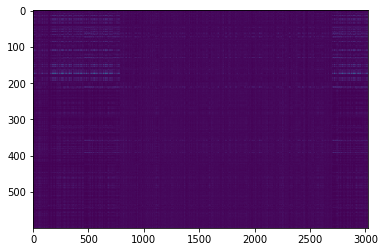

AUC      pAUC
Source_0  0.554600  0.533684
Source_1  0.544900  0.521579
Source_2  0.365200  0.508947
Target_0  0.538900  0.513684
Target_1  0.635900  0.544211
Target_2  0.432800  0.524211
mean      0.512050  0.524386
h_mean    0.495243  0.524121

2021-08-13 12:30:46,635 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:24833.540690, val_AUC_hmean:0.495243, val_pAUC_hmean:0.524121, best_flag:True
2021-08-13 12:30:46,636 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.28it/s]
2021-08-13 12:30:47,063 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.02it/s]
2021-08-13 12:30:47,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.30it/s]
2021-08-13 12:30:47,146 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:24685.050944, val_AUC_hmean:0.496272, val_pAUC_hmean:0.517315, best_flag:False
2021-08-13 12:30:47,147 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.36it/s]
2021-08-13 12:30:47,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.86it/s]
2021-08-13 12:30:47,611 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.79it/s]
2021-08-13 1

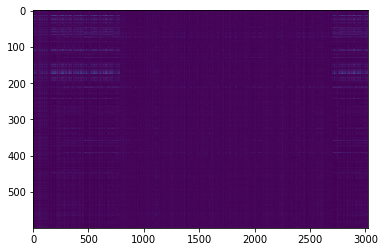

AUC      pAUC
Source_0  0.572900  0.577895
Source_1  0.576500  0.510000
Source_2  0.329400  0.485263
Target_0  0.560900  0.534211
Target_1  0.669600  0.563158
Target_2  0.460800  0.504737
mean      0.528350  0.529211
h_mean    0.501574  0.527204

2021-08-13 12:30:49,254 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:24051.971842, val_AUC_hmean:0.501574, val_pAUC_hmean:0.527204, best_flag:True
2021-08-13 12:30:49,256 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.41it/s]
2021-08-13 12:30:49,730 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.23it/s]
2021-08-13 12:30:49,780 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.55it/s]
2021-08-13 12:30:49,833 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:23894.640951, val_AUC_hmean:0.513394, val_pAUC_hmean:0.524764, best_flag:False
2021-08-13 12:30:49,834 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-08-13 12:30:50,298 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 66.28it/s]
2021-08-13 12:30:50,349 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.26it/s]


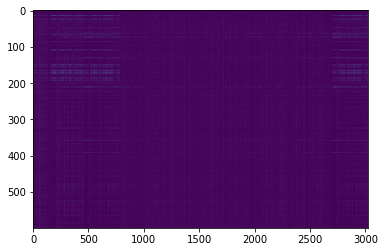

AUC      pAUC
Source_0  0.578200  0.551053
Source_1  0.608900  0.554211
Source_2  0.358300  0.492632
Target_0  0.560300  0.528947
Target_1  0.696500  0.578947
Target_2  0.432400  0.498421
mean      0.539100  0.534035
h_mean    0.512998  0.532238

2021-08-13 12:30:51,563 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:23644.856934, val_AUC_hmean:0.512998, val_pAUC_hmean:0.532238, best_flag:True
2021-08-13 12:30:51,564 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.24it/s]
2021-08-13 12:30:52,041 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.96it/s]
2021-08-13 12:30:52,080 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.58it/s]
2021-08-13 12:30:52,121 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:23293.680013, val_AUC_hmean:0.505246, val_pAUC_hmean:0.528829, best_flag:False
2021-08-13 12:30:52,122 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.57it/s]
2021-08-13 12:30:52,593 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.98it/s]
2021-08-13 12:30:52,631 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.63it/s]
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 83.51it/s]
2021-08-13 12:31:00,983 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.19it/s]
2021-08-13 12:31:01,032 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:21115.397624, val_AUC_hmean:0.493871, val_pAUC_hmean:0.522113, best_flag:False
2021-08-13 12:31:01,033 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.07it/s]
2021-08-13 12:31:01,479 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.32it/s]
2021-08-13 12:31:01,521 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.83it/s]
2021-08-13 12:31:01,564 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:20937.478678, val_AUC_hmean:0.472911, val_pAUC_hmean:0.509720, best_flag:False
2021-08-13 12:31:01,566 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.02it/s]
2021-08-13 12:31:02,012 - pytorch_modeler.py - INFO - valid_source
100%|███████

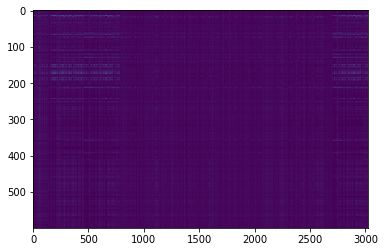

AUC      pAUC
Source_0  0.570400  0.572105
Source_1  0.604300  0.566842
Source_2  0.352500  0.489474
Target_0  0.567700  0.518947
Target_1  0.703000  0.570000
Target_2  0.427600  0.492105
mean      0.537583  0.534912
h_mean    0.509881  0.532455

2021-08-13 12:31:03,685 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:20797.683594, val_AUC_hmean:0.509881, val_pAUC_hmean:0.532455, best_flag:True
2021-08-13 12:31:03,686 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.60it/s]
2021-08-13 12:31:04,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.27it/s]
2021-08-13 12:31:04,168 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.05it/s]
2021-08-13 12:31:04,216 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:20706.929850, val_AUC_hmean:0.493784, val_pAUC_hmean:0.510660, best_flag:False
2021-08-13 12:31:04,217 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.37it/s]
2021-08-13 12:31:04,674 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.30it/s]
2021-08-13 12:31:04,732 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.96it/s]
2021-08-13 12

100%|██████████| 2/2 [00:00<00:00, 89.79it/s]
2021-08-13 12:31:12,877 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.23it/s]
2021-08-13 12:31:12,924 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:19010.836589, val_AUC_hmean:0.478816, val_pAUC_hmean:0.514323, best_flag:False
2021-08-13 12:31:12,926 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.95it/s]
2021-08-13 12:31:13,373 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.62it/s]
2021-08-13 12:31:13,415 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.54it/s]
2021-08-13 12:31:13,461 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:18894.396484, val_AUC_hmean:0.496358, val_pAUC_hmean:0.520872, best_flag:False
2021-08-13 12:31:13,462 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.55it/s]
2021-08-13 12:31:13,901 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-13 12:31:21,492 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.24it/s]
2021-08-13 12:31:21,935 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.78it/s]
2021-08-13 12:31:21,975 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.36it/s]
2021-08-13 12:31:22,023 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:17656.309570, val_AUC_hmean:0.503297, val_pAUC_hmean:0.518067, best_flag:False
2021-08-13 12:31:22,025 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.39it/s]
2021-08-13 12:31:22,465 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.01it/s]
2021-08-13 12:31:22,508 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 71.01it/s]
2021-08-13 12:31:22,564 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:17660.522624, val_AUC_hmean:0.469327, val_pAUC_hmean:0.506814, best_flag:False
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 75.93it/s]
2021-08-13 12:31:30,681 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:16547.116048, val_AUC_hmean:0.494300, val_pAUC_hmean:0.514219, best_flag:False
2021-08-13 12:31:30,682 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.27it/s]
2021-08-13 12:31:31,124 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.10it/s]
2021-08-13 12:31:31,163 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.19it/s]
2021-08-13 12:31:31,205 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:16546.711995, val_AUC_hmean:0.487501, val_pAUC_hmean:0.504819, best_flag:False
2021-08-13 12:31:31,206 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.43it/s]
2021-08-13 12:31:31,646 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.96it/s]
2021-08-13 12:31:31,688 - pytorch_modeler.py - INFO - valid_target
100%|███████

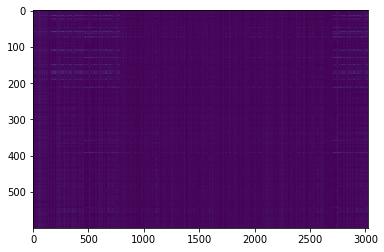

AUC      pAUC
Source_0  0.525100  0.516316
Source_1  0.603200  0.544737
Source_2  0.362400  0.545789
Target_0  0.551100  0.513684
Target_1  0.706500  0.585263
Target_2  0.402400  0.500000
mean      0.525117  0.534298
h_mean    0.498476  0.532854

2021-08-13 12:31:37,616 - pytorch_modeler.py - INFO - epoch:98/100, train_losses:15845.116536, val_AUC_hmean:0.498476, val_pAUC_hmean:0.532854, best_flag:True
2021-08-13 12:31:37,616 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.67it/s]
2021-08-13 12:31:38,052 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.02it/s]
2021-08-13 12:31:38,098 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.58it/s]
2021-08-13 12:31:38,147 - pytorch_modeler.py - INFO - epoch:99/100, train_losses:15851.330566, val_AUC_hmean:0.494837, val_pAUC_hmean:0.514274, best_flag:False
2021-08-13 12:31:38,148 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.43it/s]
2021-08-13 12:31:38,587 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.72it/s]
2021-08-13 12:31:38,628 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 73.01it/s]
2021-08-13 12

AUC      pAUC
Source_0  0.525100  0.516316
Source_1  0.603200  0.544737
Source_2  0.362400  0.545789
Target_0  0.551100  0.513684
Target_1  0.706500  0.585263
Target_2  0.402400  0.500000
mean      0.525117  0.534298
h_mean    0.498476  0.532854

2021-08-13 12:31:38,690 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-13 12:31:38,693 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:31:38,729 - 00_train.py - INFO - TRAINING


elapsed time: 73.473546982 [sec]


2021-08-13 12:31:39,005 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 27.87it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 27.82it/s]
2021-08-13 12:31:39,438 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.79it/s]
2021-08-13 12:31:39,488 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.54it/s]


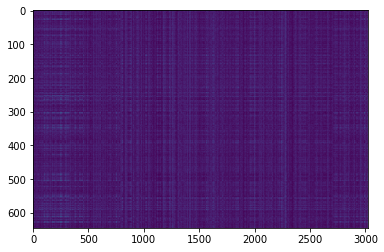

AUC      pAUC
Source_0  0.564493  0.515969
Source_1  0.454475  0.495343
Source_2  0.488527  0.482866
Target_0  0.538484  0.526783
Target_1  0.380916  0.489838
Target_2  0.485000  0.482874
mean      0.485316  0.498946
h_mean    0.477593  0.498396

2021-08-13 12:31:40,697 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:33888.429850, val_AUC_hmean:0.477593, val_pAUC_hmean:0.498396, best_flag:True
2021-08-13 12:31:40,698 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.73it/s]
2021-08-13 12:31:41,185 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.69it/s]
2021-08-13 12:31:41,229 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.27it/s]


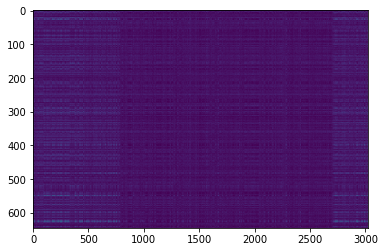

AUC      pAUC
Source_0  0.558632  0.517769
Source_1  0.457305  0.506624
Source_2  0.533951  0.496638
Target_0  0.569734  0.531352
Target_1  0.407064  0.495253
Target_2  0.530873  0.503968
mean      0.509593  0.508601
h_mean    0.502296  0.508295

2021-08-13 12:31:42,446 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:28975.753418, val_AUC_hmean:0.502296, val_pAUC_hmean:0.508295, best_flag:True
2021-08-13 12:31:42,447 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.44it/s]
2021-08-13 12:31:42,886 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.13it/s]
2021-08-13 12:31:42,931 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.59it/s]


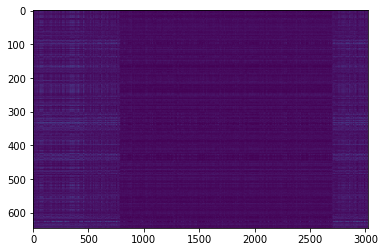

AUC      pAUC
Source_0  0.550916  0.520082
Source_1  0.469393  0.495704
Source_2  0.531200  0.510622
Target_0  0.622589  0.562114
Target_1  0.440501  0.496065
Target_2  0.550794  0.502089
mean      0.527565  0.514446
h_mean    0.520833  0.513477

2021-08-13 12:31:44,084 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:26930.029297, val_AUC_hmean:0.520833, val_pAUC_hmean:0.513477, best_flag:True
2021-08-13 12:31:44,085 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.71it/s]
2021-08-13 12:31:44,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.00it/s]
2021-08-13 12:31:44,631 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.68it/s]


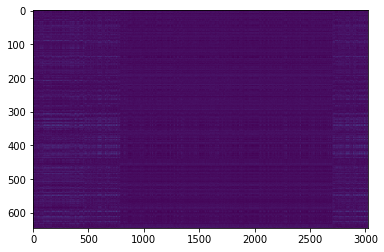

AUC      pAUC
Source_0  0.553700  0.516998
Source_1  0.487397  0.492997
Source_2  0.535293  0.509916
Target_0  0.662423  0.580897
Target_1  0.466478  0.493809
Target_2  0.570714  0.511487
mean      0.546001  0.517684
h_mean    0.539015  0.516111

2021-08-13 12:31:45,855 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:25425.974772, val_AUC_hmean:0.539015, val_pAUC_hmean:0.516111, best_flag:True
2021-08-13 12:31:45,856 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.41it/s]
2021-08-13 12:31:46,419 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.91it/s]
2021-08-13 12:31:46,467 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 80.68it/s]


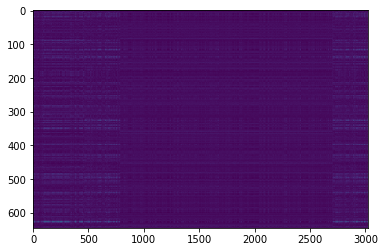

AUC      pAUC
Source_0  0.559658  0.515712
Source_1  0.500257  0.492365
Source_2  0.544954  0.506314
Target_0  0.676987  0.593689
Target_1  0.476337  0.496426
Target_2  0.574206  0.520259
mean      0.555400  0.520794
h_mean    0.548506  0.518760

2021-08-13 12:31:47,580 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:24406.433105, val_AUC_hmean:0.548506, val_pAUC_hmean:0.518760, best_flag:True
2021-08-13 12:31:47,581 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.28it/s]
2021-08-13 12:31:48,023 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 71.46it/s]
2021-08-13 12:31:48,074 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.44it/s]


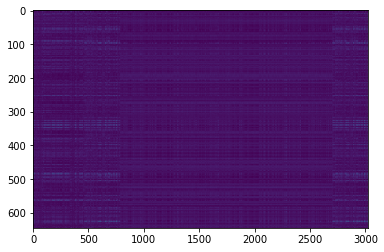

AUC      pAUC
Source_0  0.550720  0.517512
Source_1  0.481139  0.497238
Source_2  0.546430  0.502006
Target_0  0.673129  0.611862
Target_1  0.435614  0.491914
Target_2  0.587619  0.524227
mean      0.545775  0.524127
h_mean    0.535367  0.521275

2021-08-13 12:31:49,174 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:23530.608724, val_AUC_hmean:0.535367, val_pAUC_hmean:0.521275, best_flag:True
2021-08-13 12:31:49,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.08it/s]
2021-08-13 12:31:49,620 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.86it/s]
2021-08-13 12:31:49,673 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.79it/s]


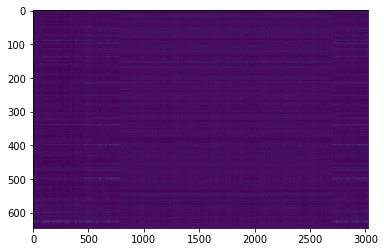

AUC      pAUC
Source_0  0.559658  0.527151
Source_1  0.513717  0.503556
Source_2  0.514962  0.513165
Target_0  0.693673  0.590542
Target_1  0.485082  0.489838
Target_2  0.558651  0.520886
mean      0.554291  0.524190
h_mean    0.547025  0.522365

2021-08-13 12:31:50,759 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:22818.945964, val_AUC_hmean:0.547025, val_pAUC_hmean:0.522365, best_flag:True
2021-08-13 12:31:50,759 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.36it/s]
2021-08-13 12:31:51,200 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.12it/s]
2021-08-13 12:31:51,246 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.82it/s]


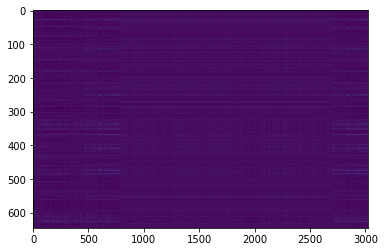

AUC      pAUC
Source_0  0.556532  0.532421
Source_1  0.502572  0.516280
Source_2  0.667002  0.551586
Target_0  0.729456  0.659377
Target_1  0.432785  0.492185
Target_2  0.681349  0.587719
mean      0.594949  0.556595
h_mean    0.574986  0.551575

2021-08-13 12:31:52,323 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:22244.203776, val_AUC_hmean:0.574986, val_pAUC_hmean:0.551575, best_flag:True
2021-08-13 12:31:52,323 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.41it/s]
2021-08-13 12:31:52,764 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.42it/s]
2021-08-13 12:31:52,820 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.48it/s]
2021-08-13 12:31:52,867 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:21882.423014, val_AUC_hmean:0.565974, val_pAUC_hmean:0.527585, best_flag:False
2021-08-13 12:31:52,868 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.05it/s]
2021-08-13 12:31:53,313 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.60it/s]
2021-08-13 12:31:53,358 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.50it/s]
2021-08-13 12:3

100%|██████████| 2/2 [00:00<00:00, 80.97it/s]
2021-08-13 12:32:01,593 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.23it/s]
2021-08-13 12:32:01,639 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:17103.092773, val_AUC_hmean:0.621224, val_pAUC_hmean:0.534228, best_flag:False
2021-08-13 12:32:01,640 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.45it/s]
2021-08-13 12:32:02,095 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.34it/s]
2021-08-13 12:32:02,140 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 76.90it/s]
2021-08-13 12:32:02,192 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:16920.553060, val_AUC_hmean:0.592620, val_pAUC_hmean:0.516772, best_flag:False
2021-08-13 12:32:02,194 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.28it/s]
2021-08-13 12:32:02,761 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-13 12:32:10,864 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.38it/s]
2021-08-13 12:32:11,304 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.99it/s]
2021-08-13 12:32:11,346 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.74it/s]
2021-08-13 12:32:11,394 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:14188.893555, val_AUC_hmean:0.560169, val_pAUC_hmean:0.512620, best_flag:False
2021-08-13 12:32:11,396 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.43it/s]
2021-08-13 12:32:11,852 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.43it/s]
2021-08-13 12:32:11,897 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.39it/s]
2021-08-13 12:32:11,950 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:13959.285156, val_AUC_hmean:0.606273, val_pAUC_hmean:0.535118, best_flag:False
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 85.15it/s]
2021-08-13 12:32:20,419 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:12138.657145, val_AUC_hmean:0.595102, val_pAUC_hmean:0.519045, best_flag:False
2021-08-13 12:32:20,420 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.06it/s]
2021-08-13 12:32:20,866 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.04it/s]
2021-08-13 12:32:20,912 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.48it/s]
2021-08-13 12:32:20,961 - pytorch_modeler.py - INFO - epoch:59/100, train_losses:11988.746338, val_AUC_hmean:0.653101, val_pAUC_hmean:0.533842, best_flag:False
2021-08-13 12:32:20,963 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.93it/s]
2021-08-13 12:32:21,411 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 70.59it/s]
2021-08-13 12:32:21,459 - pytorch_modeler.py - INFO - valid_target
100%|███████

100%|██████████| 12/12 [00:00<00:00, 26.58it/s]
2021-08-13 12:32:29,767 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 73.49it/s]
2021-08-13 12:32:29,818 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.57it/s]
2021-08-13 12:32:29,864 - pytorch_modeler.py - INFO - epoch:75/100, train_losses:10662.669840, val_AUC_hmean:0.508225, val_pAUC_hmean:0.502076, best_flag:False
2021-08-13 12:32:29,866 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.19it/s]
2021-08-13 12:32:30,325 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.69it/s]
2021-08-13 12:32:30,370 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.71it/s]
2021-08-13 12:32:30,418 - pytorch_modeler.py - INFO - epoch:76/100, train_losses:10524.126058, val_AUC_hmean:0.611489, val_pAUC_hmean:0.532221, best_flag:False
2021-08-13 12:32:30,419 - pytorch_modeler.py - INFO - train
100%|███████

2021-08-13 12:32:38,994 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.83it/s]
2021-08-13 12:32:39,444 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.58it/s]
2021-08-13 12:32:39,496 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.99it/s]
2021-08-13 12:32:39,549 - pytorch_modeler.py - INFO - epoch:92/100, train_losses:8960.386312, val_AUC_hmean:0.572196, val_pAUC_hmean:0.517247, best_flag:False
2021-08-13 12:32:39,551 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.33it/s]
2021-08-13 12:32:40,067 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.99it/s]
2021-08-13 12:32:40,118 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.11it/s]
2021-08-13 12:32:40,176 - pytorch_modeler.py - INFO - epoch:93/100, train_losses:9107.661296, val_AUC_hmean:0.649709, val_pAUC_hmean:0.535488, best_flag:False
2021-08-13 12:

AUC      pAUC
Source_0  0.556532  0.532421
Source_1  0.502572  0.516280
Source_2  0.667002  0.551586
Target_0  0.729456  0.659377
Target_1  0.432785  0.492185
Target_2  0.681349  0.587719
mean      0.594949  0.556595
h_mean    0.574986  0.551575

2021-08-13 12:32:44,199 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-08-13 12:32:44,200 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:32:44,236 - 00_train.py - INFO - TRAINING


elapsed time: 65.507728815 [sec]


2021-08-13 12:32:44,517 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 25.97it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 26.72it/s]
2021-08-13 12:32:44,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.54it/s]
2021-08-13 12:32:45,006 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.55it/s]


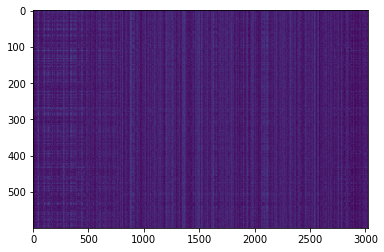

AUC      pAUC
Source_0  0.558300  0.503158
Source_1  0.510100  0.521053
Source_2  0.567100  0.567368
Target_0  0.494600  0.503158
Target_1  0.483800  0.494211
Target_2  0.463600  0.497895
mean      0.512917  0.514474
h_mean    0.510172  0.513325

2021-08-13 12:32:46,168 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:33845.128255, val_AUC_hmean:0.510172, val_pAUC_hmean:0.513325, best_flag:True
2021-08-13 12:32:46,169 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.30it/s]
2021-08-13 12:32:46,627 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.64it/s]
2021-08-13 12:32:46,670 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.68it/s]


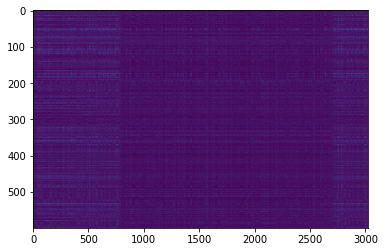

AUC      pAUC
Source_0  0.598000  0.513158
Source_1  0.563200  0.516842
Source_2  0.567300  0.557895
Target_0  0.521200  0.506842
Target_1  0.566600  0.513684
Target_2  0.478600  0.494211
mean      0.549150  0.517105
h_mean    0.546272  0.516389

2021-08-13 12:32:47,755 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:27968.158854, val_AUC_hmean:0.546272, val_pAUC_hmean:0.516389, best_flag:True
2021-08-13 12:32:47,756 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.60it/s]
2021-08-13 12:32:48,192 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.87it/s]
2021-08-13 12:32:48,235 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 87.42it/s]
2021-08-13 12:32:48,281 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:25703.052083, val_AUC_hmean:0.525255, val_pAUC_hmean:0.512299, best_flag:False
2021-08-13 12:32:48,282 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.10it/s]
2021-08-13 12:32:48,727 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.81it/s]
2021-08-13 12:32:48,766 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.44it/s]


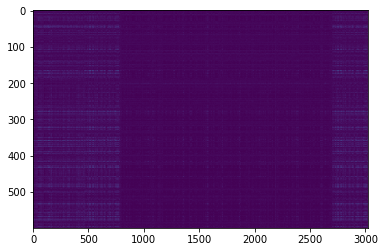

AUC      pAUC
Source_0  0.572800  0.521053
Source_1  0.523200  0.518421
Source_2  0.553100  0.540000
Target_0  0.542300  0.504737
Target_1  0.587300  0.523684
Target_2  0.429700  0.496842
mean      0.534733  0.517456
h_mean    0.529146  0.517087

2021-08-13 12:32:49,841 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:24445.855957, val_AUC_hmean:0.529146, val_pAUC_hmean:0.517087, best_flag:True
2021-08-13 12:32:49,842 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.22it/s]
2021-08-13 12:32:50,285 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 71.85it/s]
2021-08-13 12:32:50,335 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.87it/s]
2021-08-13 12:32:50,379 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:23561.094564, val_AUC_hmean:0.519376, val_pAUC_hmean:0.514059, best_flag:False
2021-08-13 12:32:50,380 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.69it/s]
2021-08-13 12:32:50,815 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.21it/s]
2021-08-13 12:32:50,856 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.74it/s]


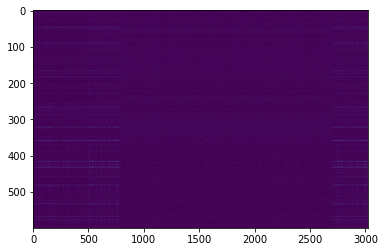

AUC      pAUC
Source_0  0.587400  0.514737
Source_1  0.527400  0.509474
Source_2  0.511300  0.535263
Target_0  0.531500  0.512632
Target_1  0.638100  0.564211
Target_2  0.407100  0.495789
mean      0.533800  0.522018
h_mean    0.523591  0.521110

2021-08-13 12:32:52,047 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:22750.949544, val_AUC_hmean:0.523591, val_pAUC_hmean:0.521110, best_flag:True
2021-08-13 12:32:52,048 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.49it/s]
2021-08-13 12:32:52,487 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.93it/s]
2021-08-13 12:32:52,532 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.70it/s]
2021-08-13 12:32:52,576 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:22042.427734, val_AUC_hmean:0.527042, val_pAUC_hmean:0.516419, best_flag:False
2021-08-13 12:32:52,577 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.27it/s]
2021-08-13 12:32:53,018 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.23it/s]
2021-08-13 12:32:53,058 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.06it/s]
2021-08-13 12:3

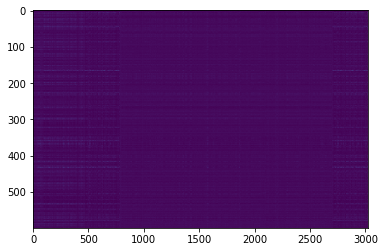

AUC      pAUC
Source_0  0.585400  0.502105
Source_1  0.444000  0.514737
Source_2  0.602700  0.536842
Target_0  0.517800  0.523158
Target_1  0.598700  0.580526
Target_2  0.437700  0.492632
mean      0.531050  0.525000
h_mean    0.521472  0.523512

2021-08-13 12:32:55,266 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:20225.240885, val_AUC_hmean:0.521472, val_pAUC_hmean:0.523512, best_flag:True
2021-08-13 12:32:55,267 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.90it/s]
2021-08-13 12:32:55,698 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.01it/s]
2021-08-13 12:32:55,741 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.41it/s]
2021-08-13 12:32:55,784 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:19625.133301, val_AUC_hmean:0.517529, val_pAUC_hmean:0.518238, best_flag:False
2021-08-13 12:32:55,785 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.77it/s]
2021-08-13 12:32:56,219 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.00it/s]
2021-08-13 12:32:56,256 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.68it/s]
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 96.49it/s]
2021-08-13 12:33:04,303 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.71it/s]
2021-08-13 12:33:04,350 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:14918.183512, val_AUC_hmean:0.527493, val_pAUC_hmean:0.509677, best_flag:False
2021-08-13 12:33:04,351 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.12it/s]
2021-08-13 12:33:04,796 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.59it/s]
2021-08-13 12:33:04,838 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.05it/s]
2021-08-13 12:33:04,885 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:14671.462484, val_AUC_hmean:0.524689, val_pAUC_hmean:0.517504, best_flag:False
2021-08-13 12:33:04,886 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.33it/s]
2021-08-13 12:33:05,311 - pytorch_modeler.py - INFO - valid_source
100%|███████

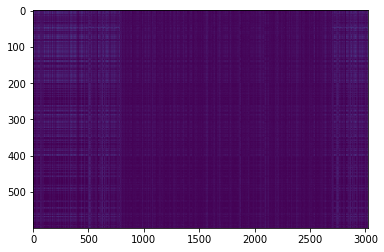

AUC      pAUC
Source_0  0.604900  0.516842
Source_1  0.460500  0.505789
Source_2  0.597400  0.544211
Target_0  0.574200  0.547895
Target_1  0.589900  0.553158
Target_2  0.483000  0.494737
mean      0.551650  0.527105
h_mean    0.545168  0.526145

2021-08-13 12:33:12,387 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:13120.810221, val_AUC_hmean:0.545168, val_pAUC_hmean:0.526145, best_flag:True
2021-08-13 12:33:12,388 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.43it/s]
2021-08-13 12:33:12,827 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.68it/s]
2021-08-13 12:33:12,876 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.13it/s]
2021-08-13 12:33:12,922 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:13086.904948, val_AUC_hmean:0.544298, val_pAUC_hmean:0.522190, best_flag:False
2021-08-13 12:33:12,923 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.53it/s]
2021-08-13 12:33:13,361 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.15it/s]
2021-08-13 12:33:13,402 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.40it/s]
2021-08-13 12

100%|██████████| 2/2 [00:00<00:00, 85.14it/s]
2021-08-13 12:33:21,432 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.58it/s]
2021-08-13 12:33:21,480 - pytorch_modeler.py - INFO - epoch:57/100, train_losses:11235.834717, val_AUC_hmean:0.501607, val_pAUC_hmean:0.505169, best_flag:False
2021-08-13 12:33:21,482 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.91it/s]
2021-08-13 12:33:21,930 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.36it/s]
2021-08-13 12:33:21,969 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.48it/s]
2021-08-13 12:33:22,013 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:11303.716064, val_AUC_hmean:0.502104, val_pAUC_hmean:0.500987, best_flag:False
2021-08-13 12:33:22,014 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.53it/s]
2021-08-13 12:33:22,452 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-13 12:33:29,949 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.93it/s]
2021-08-13 12:33:30,380 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.41it/s]
2021-08-13 12:33:30,418 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.48it/s]
2021-08-13 12:33:30,458 - pytorch_modeler.py - INFO - epoch:74/100, train_losses:9762.561605, val_AUC_hmean:0.538472, val_pAUC_hmean:0.511730, best_flag:False
2021-08-13 12:33:30,459 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.64it/s]
2021-08-13 12:33:30,895 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.91it/s]
2021-08-13 12:33:30,933 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.07it/s]
2021-08-13 12:33:30,976 - pytorch_modeler.py - INFO - epoch:75/100, train_losses:9542.734049, val_AUC_hmean:0.541395, val_pAUC_hmean:0.512375, best_flag:False
2021-08-13 12

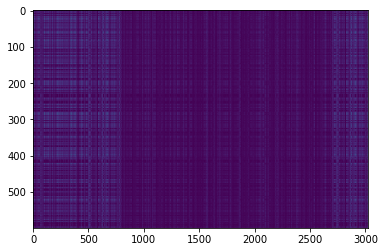

AUC      pAUC
Source_0  0.593800  0.535789
Source_1  0.443000  0.496316
Source_2  0.604800  0.537895
Target_0  0.594200  0.549474
Target_1  0.547800  0.552105
Target_2  0.518800  0.492105
mean      0.550400  0.527281
h_mean    0.543932  0.526149

2021-08-13 12:33:34,341 - pytorch_modeler.py - INFO - epoch:79/100, train_losses:9205.950846, val_AUC_hmean:0.543932, val_pAUC_hmean:0.526149, best_flag:True
2021-08-13 12:33:34,342 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.09it/s]
2021-08-13 12:33:34,787 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.51it/s]
2021-08-13 12:33:34,829 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.38it/s]


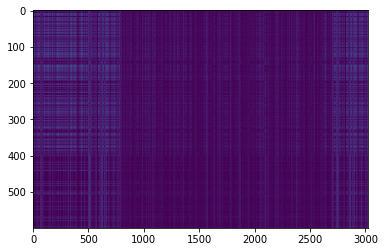

AUC      pAUC
Source_0  0.604100  0.529474
Source_1  0.440200  0.491053
Source_2  0.609200  0.533158
Target_0  0.596200  0.561053
Target_1  0.625000  0.555263
Target_2  0.523300  0.496842
mean      0.566333  0.527807
h_mean    0.557787  0.526466

2021-08-13 12:33:36,004 - pytorch_modeler.py - INFO - epoch:80/100, train_losses:9138.110026, val_AUC_hmean:0.557787, val_pAUC_hmean:0.526466, best_flag:True
2021-08-13 12:33:36,005 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.17it/s]
2021-08-13 12:33:36,465 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.07it/s]
2021-08-13 12:33:36,516 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.63it/s]


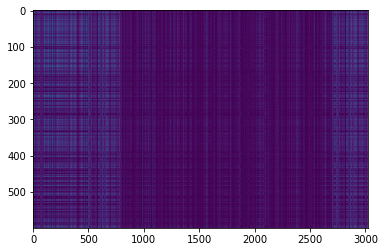

AUC      pAUC
Source_0  0.607500  0.535263
Source_1  0.489400  0.507895
Source_2  0.606900  0.529474
Target_0  0.589800  0.560526
Target_1  0.572300  0.536316
Target_2  0.515200  0.497895
mean      0.563517  0.527895
h_mean    0.559652  0.527107

2021-08-13 12:33:37,766 - pytorch_modeler.py - INFO - epoch:81/100, train_losses:9115.870199, val_AUC_hmean:0.559652, val_pAUC_hmean:0.527107, best_flag:True
2021-08-13 12:33:37,767 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.48it/s]
2021-08-13 12:33:38,222 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 80.56it/s]
2021-08-13 12:33:38,268 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.40it/s]
2021-08-13 12:33:38,317 - pytorch_modeler.py - INFO - epoch:82/100, train_losses:9200.171468, val_AUC_hmean:0.561922, val_pAUC_hmean:0.518380, best_flag:False
2021-08-13 12:33:38,318 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.06it/s]
2021-08-13 12:33:38,781 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.19it/s]
2021-08-13 12:33:38,825 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.11it/s]
2021-08-13 12:3

100%|██████████| 2/2 [00:00<00:00, 108.52it/s]
2021-08-13 12:33:47,095 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.00it/s]
2021-08-13 12:33:47,133 - pytorch_modeler.py - INFO - epoch:98/100, train_losses:8069.598185, val_AUC_hmean:0.542152, val_pAUC_hmean:0.522363, best_flag:False
2021-08-13 12:33:47,134 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.41it/s]
2021-08-13 12:33:47,558 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.79it/s]
2021-08-13 12:33:47,597 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.08it/s]
2021-08-13 12:33:47,638 - pytorch_modeler.py - INFO - epoch:99/100, train_losses:7996.028483, val_AUC_hmean:0.559413, val_pAUC_hmean:0.520776, best_flag:False
2021-08-13 12:33:47,639 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.88it/s]
2021-08-13 12:33:48,071 - pytorch_modeler.py - INFO - valid_source
100%|█████

AUC      pAUC
Source_0  0.607500  0.535263
Source_1  0.489400  0.507895
Source_2  0.606900  0.529474
Target_0  0.589800  0.560526
Target_1  0.572300  0.536316
Target_2  0.515200  0.497895
mean      0.563517  0.527895
h_mean    0.559652  0.527107

2021-08-13 12:33:48,150 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-08-13 12:33:48,151 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:33:48,182 - 00_train.py - INFO - TRAINING


elapsed time: 63.951098204 [sec]


2021-08-13 12:33:48,457 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 28.10it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 28.19it/s]
2021-08-13 12:33:48,884 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.23it/s]
2021-08-13 12:33:48,919 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.09it/s]


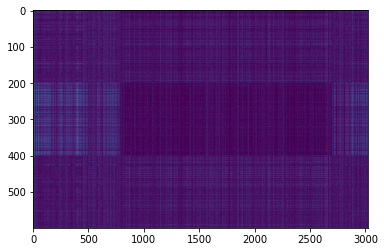

AUC      pAUC
Source_0  0.719200  0.678421
Source_1  0.468300  0.513684
Source_2  0.379600  0.482632
Target_0  0.378900  0.480526
Target_1  0.514700  0.488421
Target_2  0.481800  0.503158
mean      0.490417  0.524474
h_mean    0.468098  0.516857

2021-08-13 12:33:50,078 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:29085.076497, val_AUC_hmean:0.468098, val_pAUC_hmean:0.516857, best_flag:True
2021-08-13 12:33:50,079 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.95it/s]
2021-08-13 12:33:50,511 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.71it/s]
2021-08-13 12:33:50,545 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.24it/s]
2021-08-13 12:33:50,584 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:20907.098307, val_AUC_hmean:0.444724, val_pAUC_hmean:0.510827, best_flag:False
2021-08-13 12:33:50,585 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.47it/s]
2021-08-13 12:33:51,023 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.15it/s]
2021-08-13 12:33:51,059 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.53it/s]
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 113.70it/s]
2021-08-13 12:33:59,163 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.62it/s]
2021-08-13 12:33:59,200 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:11114.445882, val_AUC_hmean:0.524687, val_pAUC_hmean:0.499855, best_flag:False
2021-08-13 12:33:59,201 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.94it/s]
2021-08-13 12:33:59,618 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.47it/s]
2021-08-13 12:33:59,652 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.68it/s]
2021-08-13 12:33:59,690 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:10970.353678, val_AUC_hmean:0.539234, val_pAUC_hmean:0.504992, best_flag:False
2021-08-13 12:33:59,691 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.94it/s]
2021-08-13 12:34:00,122 - pytorch_modeler.py - INFO - valid_source
100%|███

2021-08-13 12:34:07,685 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.89it/s]
2021-08-13 12:34:08,168 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.68it/s]
2021-08-13 12:34:08,208 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.45it/s]
2021-08-13 12:34:08,253 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:9388.560954, val_AUC_hmean:0.544127, val_pAUC_hmean:0.502951, best_flag:False
2021-08-13 12:34:08,255 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.50it/s]
2021-08-13 12:34:08,693 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.36it/s]
2021-08-13 12:34:08,728 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.91it/s]
2021-08-13 12:34:08,771 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:9216.095133, val_AUC_hmean:0.545695, val_pAUC_hmean:0.507090, best_flag:False
2021-08-13 

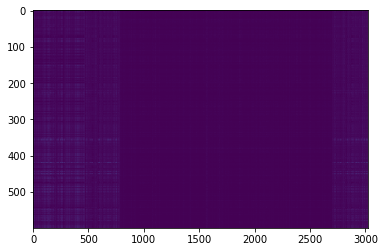

AUC      pAUC
Source_0  0.633200  0.575789
Source_1  0.585500  0.541579
Source_2  0.543000  0.475789
Target_0  0.402200  0.485263
Target_1  0.490700  0.533158
Target_2  0.615500  0.507895
mean      0.545017  0.519912
h_mean    0.532020  0.517677

2021-08-13 12:34:14,058 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:8668.103190, val_AUC_hmean:0.532020, val_pAUC_hmean:0.517677, best_flag:True
2021-08-13 12:34:14,059 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.90it/s]
2021-08-13 12:34:14,507 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.98it/s]
2021-08-13 12:34:14,550 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.58it/s]
2021-08-13 12:34:14,591 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:8605.904704, val_AUC_hmean:0.549961, val_pAUC_hmean:0.509144, best_flag:False
2021-08-13 12:34:14,592 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.51it/s]
2021-08-13 12:34:15,015 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 107.89it/s]
2021-08-13 12:34:15,051 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.98it/s]
2021-08-13 

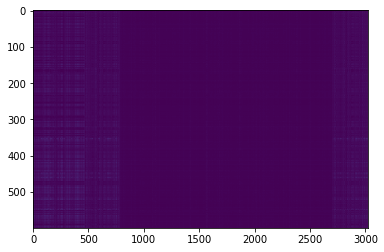

AUC      pAUC
Source_0  0.646500  0.605263
Source_1  0.585900  0.553684
Source_2  0.520600  0.475789
Target_0  0.432100  0.484737
Target_1  0.491000  0.512105
Target_2  0.615100  0.509474
mean      0.548533  0.523509
h_mean    0.538063  0.519997

2021-08-13 12:34:17,648 - pytorch_modeler.py - INFO - epoch:49/100, train_losses:8313.803304, val_AUC_hmean:0.538063, val_pAUC_hmean:0.519997, best_flag:True
2021-08-13 12:34:17,649 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.23it/s]
2021-08-13 12:34:18,190 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.08it/s]
2021-08-13 12:34:18,225 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.74it/s]
2021-08-13 12:34:18,263 - pytorch_modeler.py - INFO - epoch:50/100, train_losses:8169.546061, val_AUC_hmean:0.562725, val_pAUC_hmean:0.510777, best_flag:False
2021-08-13 12:34:18,264 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.83it/s]
2021-08-13 12:34:18,682 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.95it/s]
2021-08-13 12:34:18,717 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 109.97it/s]
2021-08-13 

100%|██████████| 2/2 [00:00<00:00, 113.90it/s]
2021-08-13 12:34:26,183 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.92it/s]
2021-08-13 12:34:26,221 - pytorch_modeler.py - INFO - epoch:66/100, train_losses:7275.115601, val_AUC_hmean:0.541741, val_pAUC_hmean:0.514063, best_flag:False
2021-08-13 12:34:26,222 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.82it/s]
2021-08-13 12:34:26,640 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.94it/s]
2021-08-13 12:34:26,675 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.32it/s]
2021-08-13 12:34:26,713 - pytorch_modeler.py - INFO - epoch:67/100, train_losses:7236.129435, val_AUC_hmean:0.540971, val_pAUC_hmean:0.509700, best_flag:False
2021-08-13 12:34:26,714 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.66it/s]
2021-08-13 12:34:27,134 - pytorch_modeler.py - INFO - valid_source
100%|█████

2021-08-13 12:34:34,288 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.86it/s]
2021-08-13 12:34:34,706 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.86it/s]
2021-08-13 12:34:34,741 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.59it/s]
2021-08-13 12:34:34,779 - pytorch_modeler.py - INFO - epoch:83/100, train_losses:6441.148804, val_AUC_hmean:0.552597, val_pAUC_hmean:0.512074, best_flag:False
2021-08-13 12:34:34,780 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.82it/s]
2021-08-13 12:34:35,198 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.66it/s]
2021-08-13 12:34:35,233 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.53it/s]
2021-08-13 12:34:35,271 - pytorch_modeler.py - INFO - epoch:84/100, train_losses:6287.788656, val_AUC_hmean:0.554354, val_pAUC_hmean:0.511020, best_flag:False
2021-08-13

100%|██████████| 2/2 [00:00<00:00, 111.92it/s]
2021-08-13 12:34:42,727 - pytorch_modeler.py - INFO - epoch:99/100, train_losses:5632.128418, val_AUC_hmean:0.548710, val_pAUC_hmean:0.510799, best_flag:False
2021-08-13 12:34:42,728 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.70it/s]
2021-08-13 12:34:43,148 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.55it/s]
2021-08-13 12:34:43,183 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.00it/s]
2021-08-13 12:34:43,222 - pytorch_modeler.py - INFO - epoch:100/100, train_losses:5626.376709, val_AUC_hmean:0.553356, val_pAUC_hmean:0.516346, best_flag:False
2021-08-13 12:34:43,223 - pytorch_modeler.py - INFO - best model, epoch:49/100, train_losses:8313.803304, val_pAUC_hmean:0.519997,


AUC      pAUC
Source_0  0.646500  0.605263
Source_1  0.585900  0.553684
Source_2  0.520600  0.475789
Target_0  0.432100  0.484737
Target_1  0.491000  0.512105
Target_2  0.615100  0.509474
mean      0.548533  0.523509
h_mean    0.538063  0.519997

2021-08-13 12:34:43,227 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-08-13 12:34:43,228 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:34:43,259 - 00_train.py - INFO - TRAINING


elapsed time: 55.076380730 [sec]


2021-08-13 12:34:43,522 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 28.69it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 28.90it/s]
2021-08-13 12:34:43,940 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 110.37it/s]
2021-08-13 12:34:43,976 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.78it/s]


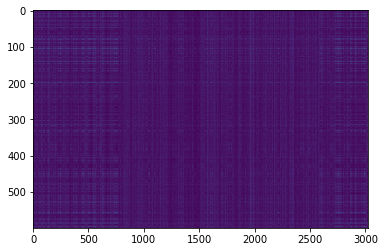

AUC      pAUC
Source_0  0.676900  0.624737
Source_1  0.487800  0.522632
Source_2  0.476000  0.477895
Target_0  0.506500  0.491053
Target_1  0.456300  0.483684
Target_2  0.505900  0.496842
mean      0.518233  0.516140
h_mean    0.509739  0.511806

2021-08-13 12:34:45,069 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:32861.262207, val_AUC_hmean:0.509739, val_pAUC_hmean:0.511806, best_flag:True
2021-08-13 12:34:45,069 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.79it/s]
2021-08-13 12:34:45,519 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 104.39it/s]
2021-08-13 12:34:45,556 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.16it/s]


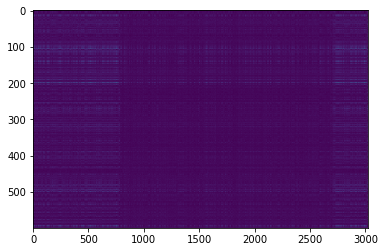

AUC      pAUC
Source_0  0.679400  0.634737
Source_1  0.532500  0.528421
Source_2  0.533700  0.492105
Target_0  0.552100  0.503158
Target_1  0.470800  0.487895
Target_2  0.538400  0.525263
mean      0.551150  0.528596
h_mean    0.544652  0.524437

2021-08-13 12:34:46,664 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:26709.590820, val_AUC_hmean:0.544652, val_pAUC_hmean:0.524437, best_flag:True
2021-08-13 12:34:46,665 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.02it/s]
2021-08-13 12:34:47,081 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.23it/s]
2021-08-13 12:34:47,116 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.00it/s]


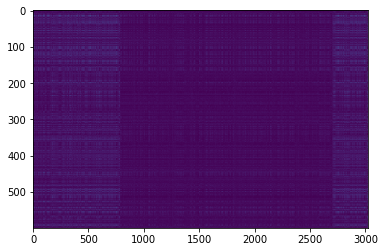

AUC      pAUC
Source_0  0.682000  0.642105
Source_1  0.518700  0.541053
Source_2  0.559600  0.517368
Target_0  0.635900  0.555263
Target_1  0.411400  0.492105
Target_2  0.583700  0.551053
mean      0.565217  0.549825
h_mean    0.550576  0.546138

2021-08-13 12:34:48,230 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:24329.004557, val_AUC_hmean:0.550576, val_pAUC_hmean:0.546138, best_flag:True
2021-08-13 12:34:48,231 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.14it/s]
2021-08-13 12:34:48,751 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.61it/s]
2021-08-13 12:34:48,787 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.86it/s]


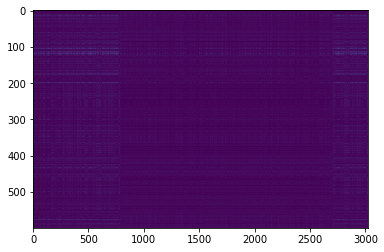

AUC      pAUC
Source_0  0.682400  0.634737
Source_1  0.585800  0.594737
Source_2  0.584400  0.538947
Target_0  0.616200  0.547895
Target_1  0.426900  0.487368
Target_2  0.572100  0.561053
mean      0.577967  0.560789
h_mean    0.566203  0.557015

2021-08-13 12:34:49,900 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:22730.423991, val_AUC_hmean:0.566203, val_pAUC_hmean:0.557015, best_flag:True
2021-08-13 12:34:49,901 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.35it/s]
2021-08-13 12:34:50,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.37it/s]
2021-08-13 12:34:50,377 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.66it/s]
2021-08-13 12:34:50,415 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:21424.551107, val_AUC_hmean:0.584781, val_pAUC_hmean:0.550846, best_flag:False
2021-08-13 12:34:50,416 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.23it/s]
2021-08-13 12:34:50,843 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.48it/s]
2021-08-13 12:34:50,877 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.09it/s]
2021-08-13 

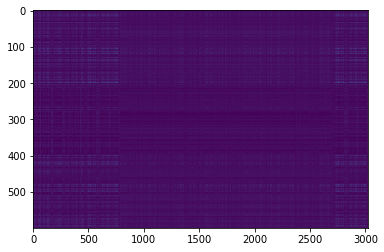

AUC      pAUC
Source_0  0.717600  0.628421
Source_1  0.786800  0.667368
Source_2  0.580900  0.537895
Target_0  0.685100  0.554737
Target_1  0.546000  0.482105
Target_2  0.572400  0.523158
mean      0.648133  0.565614
h_mean    0.636663  0.558806

2021-08-13 12:34:54,970 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:16963.426921, val_AUC_hmean:0.636663, val_pAUC_hmean:0.558806, best_flag:True
2021-08-13 12:34:54,971 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.90it/s]
2021-08-13 12:34:55,388 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.16it/s]
2021-08-13 12:34:55,423 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.27it/s]
2021-08-13 12:34:55,461 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:16496.606852, val_AUC_hmean:0.588443, val_pAUC_hmean:0.552729, best_flag:False
2021-08-13 12:34:55,462 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.88it/s]
2021-08-13 12:34:55,879 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.54it/s]
2021-08-13 12:34:55,916 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.21it/s]
2021-08-1

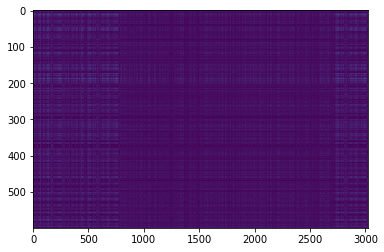

AUC      pAUC
Source_0  0.711200  0.657368
Source_1  0.825400  0.683158
Source_2  0.563300  0.543158
Target_0  0.695600  0.523158
Target_1  0.551300  0.482632
Target_2  0.530200  0.533158
mean      0.646167  0.570439
h_mean    0.629561  0.561527

2021-08-13 12:35:01,021 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:14474.187012, val_AUC_hmean:0.629561, val_pAUC_hmean:0.561527, best_flag:True
2021-08-13 12:35:01,022 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.13it/s]
2021-08-13 12:35:01,436 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.07it/s]
2021-08-13 12:35:01,471 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.74it/s]
2021-08-13 12:35:01,509 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:14284.252848, val_AUC_hmean:0.653834, val_pAUC_hmean:0.559859, best_flag:False
2021-08-13 12:35:01,510 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.92it/s]
2021-08-13 12:35:01,927 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.54it/s]
2021-08-13 12:35:01,962 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.79it/s]
2021-08-1

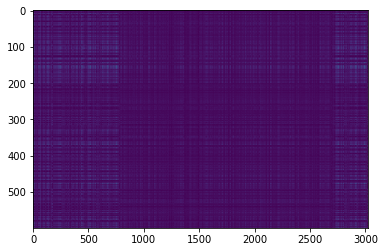

AUC      pAUC
Source_0  0.736200  0.656316
Source_1  0.847700  0.705789
Source_2  0.558300  0.535789
Target_0  0.685300  0.543684
Target_1  0.561000  0.483684
Target_2  0.514500  0.531053
mean      0.650500  0.576053
h_mean    0.630615  0.566212

2021-08-13 12:35:04,533 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:13616.140706, val_AUC_hmean:0.630615, val_pAUC_hmean:0.566212, best_flag:True
2021-08-13 12:35:04,534 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.83it/s]
2021-08-13 12:35:04,951 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.06it/s]
2021-08-13 12:35:04,992 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.16it/s]


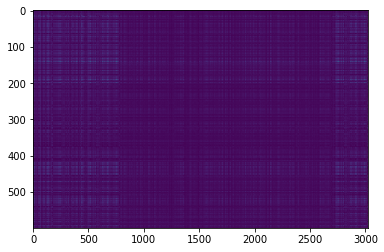

AUC      pAUC
Source_0  0.708300  0.675789
Source_1  0.840600  0.719474
Source_2  0.587700  0.537368
Target_0  0.720900  0.588421
Target_1  0.566600  0.498421
Target_2  0.557700  0.515263
mean      0.663633  0.589123
h_mean    0.648778  0.578194

2021-08-13 12:35:06,088 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:13417.223226, val_AUC_hmean:0.648778, val_pAUC_hmean:0.578194, best_flag:True
2021-08-13 12:35:06,089 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.13it/s]
2021-08-13 12:35:06,610 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.27it/s]
2021-08-13 12:35:06,646 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.79it/s]
2021-08-13 12:35:06,684 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:13288.486654, val_AUC_hmean:0.633799, val_pAUC_hmean:0.542173, best_flag:False
2021-08-13 12:35:06,685 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.87it/s]
2021-08-13 12:35:07,102 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.36it/s]
2021-08-13 12:35:07,138 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.32it/s]
2021-08-1

100%|██████████| 12/12 [00:00<00:00, 28.78it/s]
2021-08-13 12:35:14,510 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.96it/s]
2021-08-13 12:35:14,545 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.05it/s]
2021-08-13 12:35:14,583 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:11472.157389, val_AUC_hmean:0.642585, val_pAUC_hmean:0.556195, best_flag:False
2021-08-13 12:35:14,584 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.75it/s]
2021-08-13 12:35:15,004 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.80it/s]
2021-08-13 12:35:15,040 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.92it/s]
2021-08-13 12:35:15,079 - pytorch_modeler.py - INFO - epoch:46/100, train_losses:11467.948649, val_AUC_hmean:0.647820, val_pAUC_hmean:0.565071, best_flag:False
2021-08-13 12:35:15,080 - pytorch_modeler.py - INFO - train
100%|███

100%|██████████| 2/2 [00:00<00:00, 112.93it/s]
2021-08-13 12:35:22,601 - pytorch_modeler.py - INFO - epoch:61/100, train_losses:10254.697103, val_AUC_hmean:0.624691, val_pAUC_hmean:0.552915, best_flag:False
2021-08-13 12:35:22,601 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.19it/s]
2021-08-13 12:35:23,044 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.19it/s]
2021-08-13 12:35:23,079 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.72it/s]
2021-08-13 12:35:23,117 - pytorch_modeler.py - INFO - epoch:62/100, train_losses:9998.086426, val_AUC_hmean:0.639677, val_pAUC_hmean:0.567105, best_flag:False
2021-08-13 12:35:23,118 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.31it/s]
2021-08-13 12:35:23,634 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.16it/s]
2021-08-13 12:35:23,669 - pytorch_modeler.py - INFO - valid_target
100%|████

100%|██████████| 12/12 [00:00<00:00, 28.57it/s]
2021-08-13 12:35:31,262 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.72it/s]
2021-08-13 12:35:31,298 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 112.69it/s]
2021-08-13 12:35:31,336 - pytorch_modeler.py - INFO - epoch:78/100, train_losses:8924.353434, val_AUC_hmean:0.638432, val_pAUC_hmean:0.561786, best_flag:False
2021-08-13 12:35:31,337 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.52it/s]
2021-08-13 12:35:31,760 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.16it/s]
2021-08-13 12:35:31,795 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.23it/s]
2021-08-13 12:35:31,834 - pytorch_modeler.py - INFO - epoch:79/100, train_losses:8812.020589, val_AUC_hmean:0.658498, val_pAUC_hmean:0.572617, best_flag:False
2021-08-13 12:35:31,835 - pytorch_modeler.py - INFO - train
100%|█████

2021-08-13 12:35:39,470 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.21it/s]
2021-08-13 12:35:39,948 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.77it/s]
2021-08-13 12:35:39,992 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 105.27it/s]
2021-08-13 12:35:40,035 - pytorch_modeler.py - INFO - epoch:95/100, train_losses:7711.960490, val_AUC_hmean:0.653459, val_pAUC_hmean:0.539475, best_flag:False
2021-08-13 12:35:40,036 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.21it/s]
2021-08-13 12:35:40,603 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.05it/s]
2021-08-13 12:35:40,638 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.32it/s]
2021-08-13 12:35:40,678 - pytorch_modeler.py - INFO - epoch:96/100, train_losses:7823.898438, val_AUC_hmean:0.648245, val_pAUC_hmean:0.556610, best_flag:False
2021-08-13

AUC      pAUC
Source_0  0.708300  0.675789
Source_1  0.840600  0.719474
Source_2  0.587700  0.537368
Target_0  0.720900  0.588421
Target_1  0.566600  0.498421
Target_2  0.557700  0.515263
mean      0.663633  0.589123
h_mean    0.648778  0.578194

2021-08-13 12:35:42,803 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-08-13 12:35:42,804 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:35:42,838 - 00_train.py - INFO - TRAINING


elapsed time: 59.575228691 [sec]


2021-08-13 12:35:43,147 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 25.85it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 27.92it/s]
2021-08-13 12:35:43,579 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.08it/s]
2021-08-13 12:35:43,614 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.28it/s]


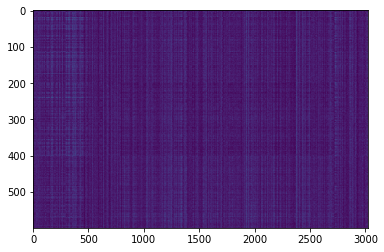

AUC      pAUC
Source_0  0.511800  0.520526
Source_1  0.484600  0.514737
Source_2  0.724200  0.578947
Target_0  0.659400  0.556842
Target_1  0.560600  0.490526
Target_2  0.672100  0.565263
mean      0.602117  0.537807
h_mean    0.589016  0.535968

2021-08-13 12:35:44,815 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:32852.025065, val_AUC_hmean:0.589016, val_pAUC_hmean:0.535968, best_flag:True
2021-08-13 12:35:44,816 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.53it/s]
2021-08-13 12:35:45,270 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.73it/s]
2021-08-13 12:35:45,309 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.21it/s]


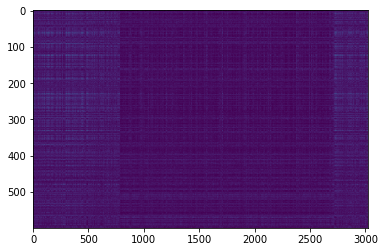

AUC      pAUC
Source_0  0.499100  0.530000
Source_1  0.493800  0.511579
Source_2  0.731500  0.616316
Target_0  0.659500  0.553158
Target_1  0.554400  0.497368
Target_2  0.617100  0.526316
mean      0.592567  0.539123
h_mean    0.580478  0.536555

2021-08-13 12:35:46,649 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:26598.759277, val_AUC_hmean:0.580478, val_pAUC_hmean:0.536555, best_flag:True
2021-08-13 12:35:46,652 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.69it/s]
2021-08-13 12:35:47,160 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 80.05it/s]
2021-08-13 12:35:47,207 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.15it/s]
2021-08-13 12:35:47,255 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:23990.127116, val_AUC_hmean:0.576974, val_pAUC_hmean:0.533067, best_flag:False
2021-08-13 12:35:47,256 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.76it/s]
2021-08-13 12:35:47,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 104.55it/s]
2021-08-13 12:35:47,780 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.57it/s]


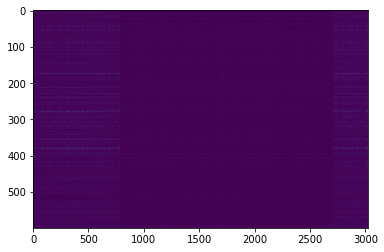

AUC      pAUC
Source_0  0.503200  0.538947
Source_1  0.556000  0.514737
Source_2  0.738800  0.636316
Target_0  0.639000  0.531053
Target_1  0.598600  0.497368
Target_2  0.629400  0.582632
mean      0.610833  0.550175
h_mean    0.602185  0.546461

2021-08-13 12:35:49,040 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:22419.650716, val_AUC_hmean:0.602185, val_pAUC_hmean:0.546461, best_flag:True
2021-08-13 12:35:49,040 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.33it/s]
2021-08-13 12:35:49,482 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.95it/s]
2021-08-13 12:35:49,533 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.61it/s]
2021-08-13 12:35:49,579 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:21195.289714, val_AUC_hmean:0.591267, val_pAUC_hmean:0.537135, best_flag:False
2021-08-13 12:35:49,580 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.55it/s]
2021-08-13 12:35:50,037 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 70.13it/s]
2021-08-13 12:35:50,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.46it/s]


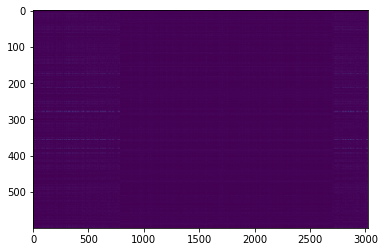

AUC      pAUC
Source_0  0.502700  0.533684
Source_1  0.615200  0.530000
Source_2  0.729500  0.670000
Target_0  0.624400  0.544211
Target_1  0.619000  0.494211
Target_2  0.660200  0.605263
mean      0.625167  0.562895
h_mean    0.617456  0.557298

2021-08-13 12:35:51,309 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:20162.835124, val_AUC_hmean:0.617456, val_pAUC_hmean:0.557298, best_flag:True
2021-08-13 12:35:51,310 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.88it/s]
2021-08-13 12:35:51,758 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.66it/s]
2021-08-13 12:35:51,795 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.32it/s]


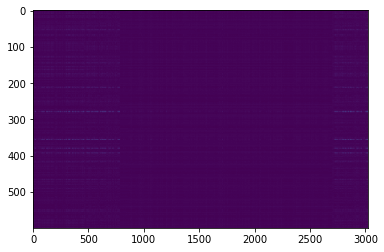

AUC      pAUC
Source_0  0.510500  0.561053
Source_1  0.603500  0.516842
Source_2  0.752500  0.650526
Target_0  0.636700  0.542105
Target_1  0.600700  0.492632
Target_2  0.670200  0.631053
mean      0.629017  0.565702
h_mean    0.620336  0.560034

2021-08-13 12:35:52,968 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:19204.267090, val_AUC_hmean:0.620336, val_pAUC_hmean:0.560034, best_flag:True
2021-08-13 12:35:52,969 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.02it/s]
2021-08-13 12:35:53,384 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.49it/s]
2021-08-13 12:35:53,420 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 107.57it/s]
2021-08-13 12:35:53,459 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:18343.470866, val_AUC_hmean:0.606589, val_pAUC_hmean:0.555406, best_flag:False
2021-08-13 12:35:53,460 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.98it/s]
2021-08-13 12:35:53,876 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.62it/s]
2021-08-13 12:35:53,912 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 108.97it/s]


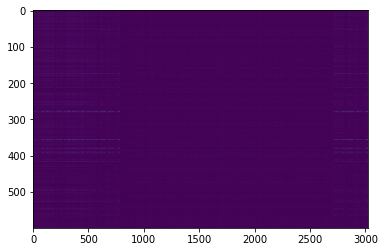

AUC      pAUC
Source_0  0.481100  0.524737
Source_1  0.611200  0.533158
Source_2  0.762200  0.716316
Target_0  0.610600  0.525263
Target_1  0.621000  0.493684
Target_2  0.673600  0.651053
mean      0.626617  0.574035
h_mean    0.614799  0.563765

2021-08-13 12:35:55,041 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:17711.480794, val_AUC_hmean:0.614799, val_pAUC_hmean:0.563765, best_flag:True
2021-08-13 12:35:55,042 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.94it/s]
2021-08-13 12:35:55,473 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 111.49it/s]
2021-08-13 12:35:55,509 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 113.02it/s]
2021-08-13 12:35:55,548 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:17017.740723, val_AUC_hmean:0.602013, val_pAUC_hmean:0.541265, best_flag:False
2021-08-13 12:35:55,549 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.88it/s]
2021-08-13 12:35:55,967 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 116.25it/s]
2021-08-13 12:35:56,001 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 111.58it/s]


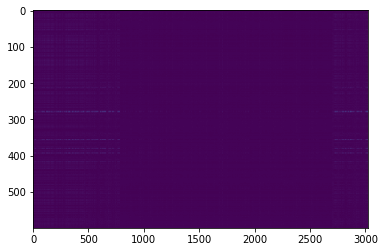

AUC      pAUC
Source_0  0.510800  0.556842
Source_1  0.664400  0.536316
Source_2  0.792200  0.685789
Target_0  0.632100  0.567368
Target_1  0.637600  0.492105
Target_2  0.657200  0.598421
mean      0.649050  0.572807
h_mean    0.638491  0.566879

2021-08-13 12:35:57,113 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:16424.118571, val_AUC_hmean:0.638491, val_pAUC_hmean:0.566879, best_flag:True
2021-08-13 12:35:57,114 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.04it/s]
2021-08-13 12:35:57,529 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 114.15it/s]
2021-08-13 12:35:57,564 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 110.94it/s]
2021-08-13 12:35:57,601 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:15905.399414, val_AUC_hmean:0.656335, val_pAUC_hmean:0.562525, best_flag:False
2021-08-13 12:35:57,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.14it/s]
2021-08-13 12:35:58,016 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.93it/s]
2021-08-13 12:35:58,052 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.48it/s]
2021-08-1

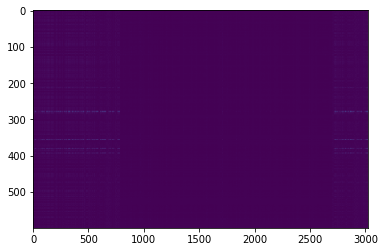

AUC      pAUC
Source_0  0.613600  0.537368
Source_1  0.631200  0.547368
Source_2  0.780400  0.738421
Target_0  0.614900  0.540000
Target_1  0.634100  0.491579
Target_2  0.655000  0.614737
mean      0.654867  0.578246
h_mean    0.650375  0.568456

2021-08-13 12:36:01,183 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:14168.098389, val_AUC_hmean:0.650375, val_pAUC_hmean:0.568456, best_flag:True
2021-08-13 12:36:01,184 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 29.10it/s]
2021-08-13 12:36:01,599 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 113.99it/s]
2021-08-13 12:36:01,633 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 115.87it/s]


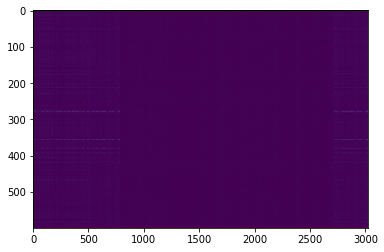

AUC      pAUC
Source_0  0.597200  0.576842
Source_1  0.689700  0.553684
Source_2  0.795000  0.709474
Target_0  0.678100  0.561053
Target_1  0.644700  0.490000
Target_2  0.655800  0.570526
mean      0.676750  0.576930
h_mean    0.671673  0.570066

2021-08-13 12:36:02,691 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:13874.572103, val_AUC_hmean:0.671673, val_pAUC_hmean:0.570066, best_flag:True
2021-08-13 12:36:02,692 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.78it/s]
2021-08-13 12:36:03,111 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.74it/s]
2021-08-13 12:36:03,147 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.08it/s]
2021-08-13 12:36:03,186 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:13640.004069, val_AUC_hmean:0.660377, val_pAUC_hmean:0.563687, best_flag:False
2021-08-13 12:36:03,187 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.30it/s]
2021-08-13 12:36:03,628 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.29it/s]
2021-08-13 12:36:03,666 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 104.96it/s]
2021-08-1

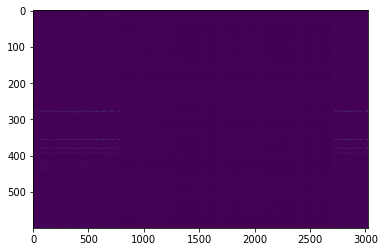

AUC      pAUC
Source_0  0.581300  0.556316
Source_1  0.683350  0.576842
Source_2  0.792800  0.754211
Target_0  0.662300  0.547895
Target_1  0.625400  0.490526
Target_2  0.654600  0.593684
mean      0.666625  0.586579
h_mean    0.660682  0.576635

2021-08-13 12:36:06,402 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:13024.026123, val_AUC_hmean:0.660682, val_pAUC_hmean:0.576635, best_flag:True
2021-08-13 12:36:06,403 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.75it/s]
2021-08-13 12:36:06,854 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.96it/s]
2021-08-13 12:36:06,893 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.94it/s]
2021-08-13 12:36:06,935 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:12690.842611, val_AUC_hmean:0.657103, val_pAUC_hmean:0.567850, best_flag:False
2021-08-13 12:36:06,936 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.73it/s]
2021-08-13 12:36:07,371 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.19it/s]
2021-08-13 12:36:07,419 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.79it/s]
2021-08-13

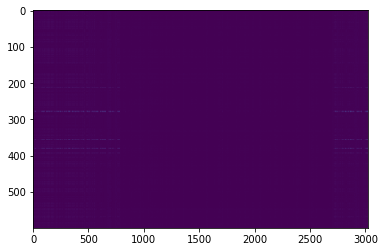

AUC      pAUC
Source_0  0.572400  0.546316
Source_1  0.656200  0.567895
Source_2  0.775500  0.752105
Target_0  0.681300  0.548421
Target_1  0.633600  0.490000
Target_2  0.679800  0.636842
mean      0.666467  0.590263
h_mean    0.660973  0.579407

2021-08-13 12:36:11,618 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:12009.713135, val_AUC_hmean:0.660973, val_pAUC_hmean:0.579407, best_flag:True
2021-08-13 12:36:11,619 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.76it/s]
2021-08-13 12:36:12,038 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.13it/s]
2021-08-13 12:36:12,074 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 116.74it/s]
2021-08-13 12:36:12,112 - pytorch_modeler.py - INFO - epoch:32/100, train_losses:11656.993327, val_AUC_hmean:0.645981, val_pAUC_hmean:0.562520, best_flag:False
2021-08-13 12:36:12,113 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.58it/s]
2021-08-13 12:36:12,535 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.65it/s]
2021-08-13 12:36:12,569 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.37it/s]
2021-08-1

100%|██████████| 12/12 [00:00<00:00, 24.13it/s]
2021-08-13 12:36:20,462 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.11it/s]
2021-08-13 12:36:20,508 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.45it/s]
2021-08-13 12:36:20,557 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:9884.347575, val_AUC_hmean:0.657565, val_pAUC_hmean:0.569331, best_flag:False
2021-08-13 12:36:20,558 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.96it/s]
2021-08-13 12:36:21,061 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.92it/s]
2021-08-13 12:36:21,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.59it/s]
2021-08-13 12:36:21,145 - pytorch_modeler.py - INFO - epoch:49/100, train_losses:9833.804606, val_AUC_hmean:0.609082, val_pAUC_hmean:0.549870, best_flag:False
2021-08-13 12:36:21,147 - pytorch_modeler.py - INFO - train
100%|█████████

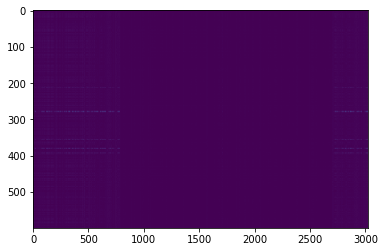

AUC      pAUC
Source_0  0.523900  0.524737
Source_1  0.724400  0.590000
Source_2  0.793200  0.748947
Target_0  0.678300  0.555789
Target_1  0.633000  0.489474
Target_2  0.656000  0.647368
mean      0.668133  0.592719
h_mean    0.657291  0.581237

2021-08-13 12:36:25,504 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:9421.223633, val_AUC_hmean:0.657291, val_pAUC_hmean:0.581237, best_flag:True
2021-08-13 12:36:25,505 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.73it/s]
2021-08-13 12:36:25,956 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 103.45it/s]
2021-08-13 12:36:25,997 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 105.46it/s]
2021-08-13 12:36:26,039 - pytorch_modeler.py - INFO - epoch:56/100, train_losses:9278.258708, val_AUC_hmean:0.601903, val_pAUC_hmean:0.539176, best_flag:False
2021-08-13 12:36:26,040 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.74it/s]
2021-08-13 12:36:26,474 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.45it/s]
2021-08-13 12:36:26,515 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.86it/s]
2021-08-13 12

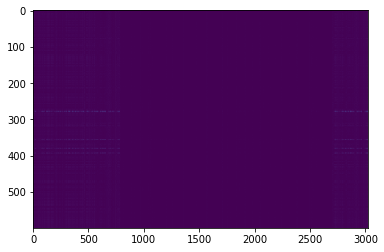

AUC      pAUC
Source_0  0.620800  0.557895
Source_1  0.715000  0.591579
Source_2  0.751200  0.760000
Target_0  0.729800  0.560526
Target_1  0.626500  0.496842
Target_2  0.650100  0.612632
mean      0.682233  0.596579
h_mean    0.678329  0.586643

2021-08-13 12:36:33,130 - pytorch_modeler.py - INFO - epoch:67/100, train_losses:8261.069824, val_AUC_hmean:0.678329, val_pAUC_hmean:0.586643, best_flag:True
2021-08-13 12:36:33,131 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.20it/s]
2021-08-13 12:36:33,574 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.47it/s]
2021-08-13 12:36:33,615 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.08it/s]
2021-08-13 12:36:33,658 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:8201.545980, val_AUC_hmean:0.609118, val_pAUC_hmean:0.540134, best_flag:False
2021-08-13 12:36:33,659 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.46it/s]
2021-08-13 12:36:34,098 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 104.38it/s]
2021-08-13 12:36:34,134 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.25it/s]
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 91.86it/s]
2021-08-13 12:36:42,508 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.06it/s]
2021-08-13 12:36:42,550 - pytorch_modeler.py - INFO - epoch:84/100, train_losses:7196.324178, val_AUC_hmean:0.637950, val_pAUC_hmean:0.570827, best_flag:False
2021-08-13 12:36:42,552 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.25it/s]
2021-08-13 12:36:42,994 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.29it/s]
2021-08-13 12:36:43,038 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.09it/s]
2021-08-13 12:36:43,085 - pytorch_modeler.py - INFO - epoch:85/100, train_losses:7128.165853, val_AUC_hmean:0.640498, val_pAUC_hmean:0.571687, best_flag:False
2021-08-13 12:36:43,086 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-08-13 12:36:43,543 - pytorch_modeler.py - INFO - valid_source
100%|████████

2021-08-13 12:36:51,146 - pytorch_modeler.py - INFO - best model, epoch:67/100, train_losses:8261.069824, val_pAUC_hmean:0.586643,


AUC      pAUC
Source_0  0.620800  0.557895
Source_1  0.715000  0.591579
Source_2  0.751200  0.760000
Target_0  0.729800  0.560526
Target_1  0.626500  0.496842
Target_2  0.650100  0.612632
mean      0.682233  0.596579
h_mean    0.678329  0.586643

2021-08-13 12:36:51,151 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-08-13 12:36:51,152 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-13 12:36:51,194 - 00_train.py - INFO - TRAINING


elapsed time: 68.347579718 [sec]


2021-08-13 12:36:51,457 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 26.48it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 26.60it/s]
2021-08-13 12:36:51,910 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.49it/s]
2021-08-13 12:36:51,953 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.76it/s]


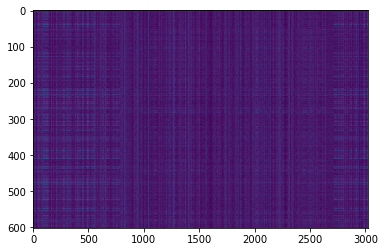

AUC      pAUC
Source_0  0.554300  0.507368
Source_1  0.533800  0.502105
Source_2  0.687879  0.587203
Target_0  0.629200  0.575789
Target_1  0.479184  0.508485
Target_2  0.580834  0.550982
mean      0.577533  0.538656
h_mean    0.569852  0.536487

2021-08-13 12:36:53,103 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:32696.061198, val_AUC_hmean:0.569852, val_pAUC_hmean:0.536487, best_flag:True
2021-08-13 12:36:53,104 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.92it/s]
2021-08-13 12:36:53,536 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.80it/s]
2021-08-13 12:36:53,579 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.46it/s]


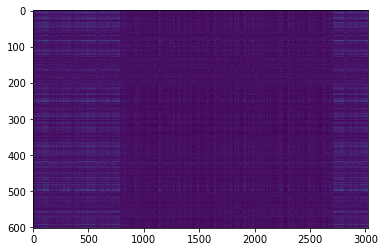

AUC      pAUC
Source_0  0.602500  0.503684
Source_1  0.509600  0.521579
Source_2  0.694118  0.611127
Target_0  0.647500  0.589474
Target_1  0.444082  0.511278
Target_2  0.624760  0.575872
mean      0.587093  0.552169
h_mean    0.573635  0.549061

2021-08-13 12:36:54,743 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:25745.751628, val_AUC_hmean:0.573635, val_pAUC_hmean:0.549061, best_flag:True
2021-08-13 12:36:54,745 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.95it/s]
2021-08-13 12:36:55,209 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.77it/s]
2021-08-13 12:36:55,252 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.69it/s]


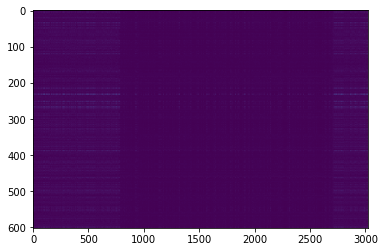

AUC      pAUC
Source_0  0.580100  0.504211
Source_1  0.534500  0.534737
Source_2  0.731729  0.642086
Target_0  0.645400  0.586842
Target_1  0.416735  0.500859
Target_2  0.634371  0.566260
mean      0.590473  0.555833
h_mean    0.572149  0.551604

2021-08-13 12:36:56,440 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:22626.811849, val_AUC_hmean:0.572149, val_pAUC_hmean:0.551604, best_flag:True
2021-08-13 12:36:56,441 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.87it/s]
2021-08-13 12:36:56,907 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.61it/s]
2021-08-13 12:36:56,947 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.75it/s]


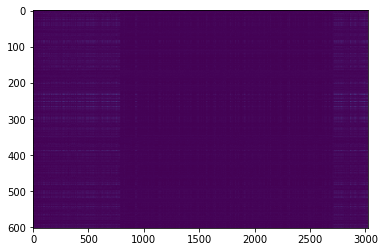

AUC      pAUC
Source_0  0.535300  0.521053
Source_1  0.584300  0.540526
Source_2  0.767558  0.688057
Target_0  0.643400  0.572105
Target_1  0.469694  0.500752
Target_2  0.633026  0.570003
mean      0.605546  0.565416
h_mean    0.591401  0.559602

2021-08-13 12:36:58,235 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:20650.713053, val_AUC_hmean:0.591401, val_pAUC_hmean:0.559602, best_flag:True
2021-08-13 12:36:58,236 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.20it/s]
2021-08-13 12:36:58,696 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.74it/s]
2021-08-13 12:36:58,736 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.96it/s]
2021-08-13 12:36:58,778 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:19119.679525, val_AUC_hmean:0.581173, val_pAUC_hmean:0.552868, best_flag:False
2021-08-13 12:36:58,779 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.87it/s]
2021-08-13 12:36:59,245 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.23it/s]
2021-08-13 12:36:59,284 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.42it/s]
2021-08-13 12:

100%|██████████| 2/2 [00:00<00:00, 97.39it/s]
2021-08-13 12:37:07,348 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.58it/s]
2021-08-13 12:37:07,395 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:12354.718262, val_AUC_hmean:0.615301, val_pAUC_hmean:0.544393, best_flag:False
2021-08-13 12:37:07,397 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.70it/s]
2021-08-13 12:37:07,832 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.11it/s]
2021-08-13 12:37:07,871 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 15.04it/s]
2021-08-13 12:37:08,029 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:12215.359456, val_AUC_hmean:0.611870, val_pAUC_hmean:0.542971, best_flag:False
2021-08-13 12:37:08,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.18it/s]
2021-08-13 12:37:08,474 - pytorch_modeler.py - INFO - valid_source
100%|███████

2021-08-13 12:37:16,156 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.94it/s]
2021-08-13 12:37:16,604 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.23it/s]
2021-08-13 12:37:16,643 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.49it/s]
2021-08-13 12:37:16,687 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:10001.098551, val_AUC_hmean:0.614064, val_pAUC_hmean:0.548495, best_flag:False
2021-08-13 12:37:16,688 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.20it/s]
2021-08-13 12:37:17,131 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.36it/s]
2021-08-13 12:37:17,174 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.54it/s]
2021-08-13 12:37:17,223 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:10056.901530, val_AUC_hmean:0.626647, val_pAUC_hmean:0.545124, best_flag:False
2021-08-13 1

100%|██████████| 2/2 [00:00<00:00, 88.33it/s]
2021-08-13 12:37:25,255 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:8737.913330, val_AUC_hmean:0.639578, val_pAUC_hmean:0.556290, best_flag:False
2021-08-13 12:37:25,256 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.18it/s]
2021-08-13 12:37:25,699 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.79it/s]
2021-08-13 12:37:25,738 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.93it/s]
2021-08-13 12:37:25,781 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:8691.481689, val_AUC_hmean:0.613682, val_pAUC_hmean:0.541260, best_flag:False
2021-08-13 12:37:25,782 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.70it/s]
2021-08-13 12:37:26,217 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.03it/s]
2021-08-13 12:37:26,261 - pytorch_modeler.py - INFO - valid_target
100%|█████████

100%|██████████| 12/12 [00:00<00:00, 26.95it/s]
2021-08-13 12:37:34,365 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.44it/s]
2021-08-13 12:37:34,404 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.59it/s]
2021-08-13 12:37:34,448 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:7662.643473, val_AUC_hmean:0.606015, val_pAUC_hmean:0.547933, best_flag:False
2021-08-13 12:37:34,449 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.68it/s]
2021-08-13 12:37:34,884 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.30it/s]
2021-08-13 12:37:34,929 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 68.97it/s]
2021-08-13 12:37:34,981 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:7494.409139, val_AUC_hmean:0.616896, val_pAUC_hmean:0.552281, best_flag:False
2021-08-13 12:37:34,982 - pytorch_modeler.py - INFO - train
100%|████████

2021-08-13 12:37:43,149 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.27it/s]
2021-08-13 12:37:43,591 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 100.00it/s]
2021-08-13 12:37:43,629 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 103.41it/s]
2021-08-13 12:37:43,673 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:6537.571126, val_AUC_hmean:0.632682, val_pAUC_hmean:0.548237, best_flag:False
2021-08-13 12:37:43,675 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.75it/s]
2021-08-13 12:37:44,109 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.16it/s]
2021-08-13 12:37:44,147 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.04it/s]
2021-08-13 12:37:44,190 - pytorch_modeler.py - INFO - epoch:89/100, train_losses:6468.896362, val_AUC_hmean:0.626882, val_pAUC_hmean:0.549311, best_flag:False
2021-08-13 

AUC      pAUC
Source_0  0.535300  0.521053
Source_1  0.584300  0.540526
Source_2  0.767558  0.688057
Target_0  0.643400  0.572105
Target_1  0.469694  0.500752
Target_2  0.633026  0.570003
mean      0.605546  0.565416
h_mean    0.591401  0.559602

elapsed time: 59.054223061 [sec]


In [18]:
for machine_type in machine_types:
      run(machine_type)

In [19]:
#run(machine_types[5])